# EECS 442 Assignment 5(3): Semantic Segmentaion
In this part, you will design and implement your Convolutional Neural Networks to perform semantic segmentation on the Mini Facade dataset.

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Leo Lee, #02047414

## Setup
First, we will install some required packages for this notebook and download the Mini Facade dataset. 


In [1]:
# install required packages and download the dataset
!pip install colormap easydev pypng
!wget http://web.eecs.umich.edu/~justincj/teaching/eecs442/resources/facades.zip
!unzip facades.zip

     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 655kB 11.5MB/s 
  Created wheel for colormap: filename=colormap-1.0.3-cp37-none-any.whl size=15561 sha256=33db6bc851700489cf8555f160370a185eee779abbae9a47e9f8189356cced94
  Stored in directory: /root/.cache/pip/wheels/b5/c4/23/5f5d3e77fb0d00f44ee147a9cbb3acb641b9ebe2f3d5406c66
  Created wheel for easydev: filename=easydev-0.11.0-cp37-none-any.whl size=64244 sha256=fc6ef441b19c4d31603e6f2eb2af18daa18ebbc40d9cb5344b8b5b2628b38bf2
  Stored in directory: /root/.cache/pip/wheels/17/69/b5/771949d8100a30aa33e4bc5d0ff77eced9063284891ce26898
  Created wheel for pypng: filename=pypng-0.0.20-cp37-none-any.whl size=67163 sha256=2f339c8a7c28b2fb877dad5501c6b9b9c1212be35c4cb047a9bf803611bdb8d1
  Stored in directory: /root/.cache/pip/wheels/41/6b/ef/0493b536b6d4722c2ae9486691b1d49b922b9877922beeabb3
Successfully built colormap easydev pypng
--2021-04-13 03:36:48--  http://web.eecs.umich.edu/~justincj/teachin

In [2]:
import os
import time
import cv2
import matplotlib.pyplot as plt
import numpy as np
import png
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from PIL import Image
import torchvision
from colormap.colors import Color, hex2rgb
from sklearn.metrics import average_precision_score as ap_score
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import Dataset
from tqdm import tqdm

In [3]:
if torch.cuda.is_available():
    print("Using the GPU. You are good to go!")
    device = torch.device('cuda:0')
else:
    raise Exception("WARNING: Could not find GPU! Using CPU only. \
To enable GPU, please to go Edit > Notebook Settings > Hardware \
Accelerator and select GPU.")

Using the GPU. You are good to go!


## Dataset
We will create a custom Dataset function for the Mini Facade dataset. You don't have to change anything here.

In [4]:
class FacadeDataset(Dataset):
  def __init__(self, flag, dataDir='./facades/', data_range=(0, 8), n_class=5, 
               onehot=False):
    self.onehot = onehot
    assert(flag in ['train', 'eval', 'test', 'test_dev', 'kaggle'])
    print("load "+ flag+" dataset start")
    print("    from: %s" % dataDir)
    print("    range: [%d, %d)" % (data_range[0], data_range[1]))
    self.dataset = []
    for i in range(data_range[0], data_range[1]):
      img = Image.open(os.path.join(dataDir,flag,'eecs442_%04d.jpg' % i))

      pngreader = png.Reader(filename=os.path.join(dataDir,flag,
                                                   'eecs442_%04d.png' % i))
      w,h,row,info = pngreader.read()
      label = np.array(list(row)).astype('uint8')

      # Normalize input image
      img = np.asarray(img).astype("f").transpose(2, 0, 1)/128.0-1.0
      # Convert to n_class-dimensional onehot matrix
      label_ = np.asarray(label)
      label = np.zeros((n_class, img.shape[1], img.shape[2])).astype("i")
      for j in range(n_class):
          label[j, :] = label_ == j
      self.dataset.append((img, label))
    print("load dataset done")

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index):
    img, label = self.dataset[index]
    label = torch.FloatTensor(label)
    if not self.onehot:
      label = torch.argmax(label, dim=0)
    else:
      label = label.long()

    return torch.FloatTensor(img), torch.LongTensor(label)

Now, we will create a dataloader for the Mini Facade dataset. You have to play with the size of train-val split and adjust the batch sizes for the splits.

In [6]:
N_CLASS=5
##############################################################################
# TODO: Change data_range so that train_data and val_data splits the 906     #
# samples under "train" folder. You can decide how to split.                 #
#                                                                            # 
# TODO: Adjust batch_size for loaders                                        #
##############################################################################
train_data = FacadeDataset(flag='train', data_range=(0,750), onehot=False)
train_loader = DataLoader(train_data, batch_size=4)
val_data = FacadeDataset(flag='train', data_range=(750,906), onehot=False)
val_loader = DataLoader(val_data, batch_size=4)
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################
test_data = FacadeDataset(flag='test_dev', data_range=(0,114), onehot=False)
test_loader = DataLoader(test_data, batch_size=1)

# ap_loader for calculating Average Precision
ap_data = FacadeDataset(flag='test_dev', data_range=(0,114), onehot=True)
ap_loader = DataLoader(ap_data, batch_size=1)

load train dataset start
    from: ./facades/
    range: [0, 750)
load dataset done
load train dataset start
    from: ./facades/
    range: [750, 906)
load dataset done
load test_dev dataset start
    from: ./facades/
    range: [0, 114)
load dataset done
load test_dev dataset start
    from: ./facades/
    range: [0, 114)
load dataset done


## Model
Design and implement your Convolutional NeuralNetworks to perform semantic segmentation on the Mini Facade dataset. 

You can build a simple neural network based on the U-net [1]:
1. Conv-ReLU-Conv-ReLU that goes from `3 -> 64 -> 64` ( H x W )
2. Maxpool (`nn.MaxPool2d`) to reduce the size of the feature map by half ( H/2 x W/2 )
3. Conv-ReLU-Conv-ReLU that goes from `64 -> 128 -> 128` ( H/2 x W/2 )
4. Maxpool (`nn.MaxPool2d`) to reduce the size of the feature map by half ( H/4 x W/4 )
5. Conv that goes from `128 -> 128` ( H/4 x W/4 )
6. Upsample (`nn.Upsample`) to increase of size of the feature map by two ( H/2 x W/2 )
6. Conv-ReLU-Conv-ReLU that goes from `128 -> 64 -> 64` ( H/2 x W/2 )
7. Upsample (`nn.Upsample`) to increase of size of the feature map by two ( H x W )
8. Conv-ReLU-Conv-ReLU that goes from `64 -> 64 -> 5` ( H x W )

Be careful while choosing the kernel size, padding and stride in the convolution layer. You can compute the output shape after a convolution by using the formula:

$$
X_{out} = (X_{in} - K + 2P)/S +1
$$

Where, $X_{out}$ & $X_{in}$ are the output and input shape of the feature map and $K$, $P$ & $S$ are the kernel size, padding and stride repectively.

[1] O. Ronneberger, P. Fischer, and T. Brox, “U-net:  Convolutional networks for biomedical image seg-mentation,”ArXiv, vol. abs/1505.04597, 2015

In [7]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.n_class = N_CLASS
    ########################################################################
    # TODO: Implement a sematic segmentation model                         #
    ########################################################################
    self.layers = nn.Sequential(
        #1
        nn.Conv2d(3, 64, 3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, 3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        #2
        nn.MaxPool2d(2, stride=2),
        #3
        nn.Conv2d(64, 128, 3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, 3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        #4
        nn.MaxPool2d(2, stride=2),
        #5
        nn.Conv2d(128, 128, 3, stride=1, padding=1),
        #6
        nn.Upsample(scale_factor=2, mode='bilinear'),
        #7
        nn.Conv2d(128, 64, 3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, 3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        #8
        nn.Upsample(scale_factor=2, mode='bilinear'),
        #9
        nn.Conv2d(64, 64, 3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 5, 3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        #nn.Conv2d(3, self.n_class, 1, padding=0),
        #nn.ReLU(inplace=True),
        )
    ########################################################################
    #                             END OF YOUR CODE                         #
    ########################################################################

  def forward(self, x):
    ########################################################################
    # TODO: Implement the forward pass                                     #
    ########################################################################
    x = self.layers(x)
    ########################################################################
    #                             END OF YOUR CODE                         #
    ########################################################################
    return x

Ininitialize your model and look at the structure of your model, [torchsummary](https://github.com/sksq96/pytorch-summary) is a useful library to look at the computation graph of your model.

In [8]:
name = 'starter_net'
net = Net().to(device)
# visualizing the model
print('Your network:')
summary(net, (3,224,224))

Your network:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 128, 56, 56]         147,584
         Upsample-12        [-1, 128, 112, 112]               0
           Conv2d-13         [-1, 64, 112, 112]          73,792
             ReLU-14     

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Once you have completed the model implementation in the cell above, run the cell below to load helper functions and train the model.

In [9]:
def save_label(label, path):
  '''
  Function for ploting labels.
  '''
  colormap = [
      '#000000',
      '#0080FF',
      '#80FF80',
      '#FF8000',
      '#FF0000',
  ]
  assert(np.max(label)<len(colormap))
  colors = [hex2rgb(color, normalise=False) for color in colormap]
  w = png.Writer(label.shape[1], label.shape[0], palette=colors, bitdepth=4)
  with open(path, 'wb') as f:
      w.write(f, label)

def train(trainloader, net, criterion, optimizer, device, epoch):
  '''
  Function for training.
  '''
  start = time.time()
  running_loss = 0.0
  cnt = 0
  net = net.train()
  for images, labels in tqdm(trainloader):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    output = net(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    cnt += 1
  end = time.time()
  running_loss /= cnt
  print('\n [epoch %d] loss: %.3f elapsed time %.3f' %
        (epoch, running_loss, end-start))
  return running_loss

def test(testloader, net, criterion, device):
  '''
  Function for testing.
  '''
  losses = 0.
  cnt = 0
  with torch.no_grad():
    net = net.eval()
    for images, labels in tqdm(testloader):
      images = images.to(device)
      labels = labels.to(device)
      output = net(images)
      loss = criterion(output, labels)
      losses += loss.item()
      cnt += 1
  print('\n',losses / cnt)
  return (losses/cnt)


def cal_AP(testloader, net, criterion, device):
  '''
  Calculate Average Precision
  '''
  losses = 0.
  cnt = 0
  with torch.no_grad():
    net = net.eval()
    preds = [[] for _ in range(5)]
    heatmaps = [[] for _ in range(5)]
    for images, labels in tqdm(testloader):
      images = images.to(device)
      labels = labels.to(device)
      output = net(images).cpu().numpy()
      for c in range(5):
        preds[c].append(output[:, c].reshape(-1))
        heatmaps[c].append(labels[:, c].cpu().numpy().reshape(-1))

    aps = []
    for c in range(5):
      preds[c] = np.concatenate(preds[c])
      heatmaps[c] = np.concatenate(heatmaps[c])
      if heatmaps[c].max() == 0:
        ap = float('nan')
      else:
        ap = ap_score(heatmaps[c], preds[c])
        aps.append(ap)
      print("AP = {}".format(ap))
    print("Average Precision (all classes) = {}".format(np.mean(aps)))
  return None


def get_result(testloader, net, device, folder='output_train'):
  result = []
  cnt = 1
  os.makedirs(folder, exist_ok=True)
  with torch.no_grad():
    net = net.eval()
    cnt = 0
    for images, labels in tqdm(testloader):
      images = images.to(device)
      labels = labels.to(device)
      output = net(images)[0].cpu().numpy()
      c, h, w = output.shape
      assert(c == N_CLASS)
      y = np.argmax(output, 0).astype('uint8')
      gt = labels.cpu().data.numpy().squeeze(0).astype('uint8')
      save_label(y, './{}/y{}.png'.format(folder, cnt))
      save_label(gt, './{}/gt{}.png'.format(folder, cnt))
      plt.imsave('./{}/x{}.png'.format(folder, cnt),
                 ((images[0].cpu().data.numpy()+1)*128).astype(np.uint8).transpose(1,2,0))
      cnt += 1

def plot_hist(trn_hist, val_hist):
    x = np.arange(len(trn_hist))
    plt.figure()
    plt.plot(x, trn_hist)
    plt.plot(x, val_hist)
    plt.legend(['Training', 'Validation'])
    plt.xticks(x)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

Experiment with with different optimizers, parameters (such as learning rate) and number of epochs. We expect you to achieve **0.45 AP** on the test set

  0%|          | 0/188 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
  1%|          | 1/188 [00:00<00:34,  5.45it/s]


Start training
-----------------Epoch = 1-----------------


  5%|▌         | 2/39 [00:00<00:02, 12.66it/s]


 [epoch 1] loss: 0.708 elapsed time 25.184
Validation loss: 


  1%|          | 1/188 [00:00<00:27,  6.74it/s]


 0.7242732323133029
-----------------Epoch = 2-----------------


  5%|▌         | 2/39 [00:00<00:02, 12.65it/s]


 [epoch 2] loss: 0.700 elapsed time 24.996
Validation loss: 


  1%|          | 1/188 [00:00<00:28,  6.61it/s]


 0.719111564831856
-----------------Epoch = 3-----------------


  5%|▌         | 2/39 [00:00<00:02, 12.50it/s]


 [epoch 3] loss: 0.693 elapsed time 24.948
Validation loss: 


  1%|          | 1/188 [00:00<00:27,  6.81it/s]


 0.7142381561108124
-----------------Epoch = 4-----------------


  5%|▌         | 2/39 [00:00<00:02, 12.50it/s]


 [epoch 4] loss: 0.687 elapsed time 24.972
Validation loss: 


  1%|          | 1/188 [00:00<00:27,  6.76it/s]


 0.7098415646797571
-----------------Epoch = 5-----------------


  5%|▌         | 2/39 [00:00<00:03, 11.93it/s]


 [epoch 5] loss: 0.680 elapsed time 24.919
Validation loss: 


  1%|          | 1/188 [00:00<00:26,  6.93it/s]


 0.7054703984505091
-----------------Epoch = 6-----------------


  5%|▌         | 2/39 [00:00<00:02, 12.50it/s]


 [epoch 6] loss: 0.674 elapsed time 24.936
Validation loss: 


  1%|          | 1/188 [00:00<00:27,  6.84it/s]


 0.7019800543785095
-----------------Epoch = 7-----------------


  5%|▌         | 2/39 [00:00<00:02, 12.36it/s]


 [epoch 7] loss: 0.668 elapsed time 24.897
Validation loss: 


  1%|          | 1/188 [00:00<00:26,  6.95it/s]


 0.697362727079636
-----------------Epoch = 8-----------------


  5%|▌         | 2/39 [00:00<00:02, 12.34it/s]


 [epoch 8] loss: 0.662 elapsed time 24.981
Validation loss: 


  1%|          | 1/188 [00:00<00:27,  6.75it/s]


 0.6934341283944937
-----------------Epoch = 9-----------------


  5%|▌         | 2/39 [00:00<00:03, 11.84it/s]


 [epoch 9] loss: 0.656 elapsed time 25.076
Validation loss: 


  1%|          | 1/188 [00:00<00:27,  6.76it/s]


 0.6898875740858225
-----------------Epoch = 10-----------------


  5%|▌         | 2/39 [00:00<00:03, 11.97it/s]


 [epoch 10] loss: 0.650 elapsed time 25.160
Validation loss: 


100%|██████████| 39/39 [00:03<00:00, 11.95it/s]



 0.6850022979271717


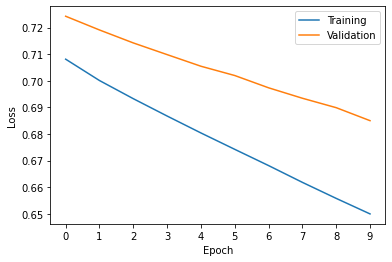

  0%|          | 0/114 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)



Finished Training, Testing on test set


  2%|▏         | 2/114 [00:00<00:09, 11.25it/s]


 0.7730954898553982

Generating Unlabeled Result


100%|██████████| 114/114 [00:01<00:00, 93.38it/s] 


AP = 0.5830868006792328
AP = 0.5709136559282681
AP = 0.02803467867667215
AP = 0.8277767032702229
AP = 0.4278602954994534
Average Precision (all classes) = 0.48753442681076986
CPU times: user 4min 3s, sys: 1min 5s, total: 5min 9s
Wall time: 5min 7s


In [16]:
%%time
criterion = nn.CrossEntropyLoss()
##############################################################################
# TODO: Modify the lines below to experiment with different optimizers,      #
# parameters (such as learning rate) and number of epochs.                   #
##############################################################################
optimizer = torch.optim.Adam(net.parameters(), 1e-4, weight_decay=1e-5)
#optimizer = torch.optim.SGD(net.parameters(), 5e-4, weight_decay=1e-5)
num_epoch = 10
##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################

print('\nStart training')
trn_hist = []
val_hist = []
for epoch in range(num_epoch): #TODO: Change the number of epochs
  print('-----------------Epoch = %d-----------------' % (epoch+1))
  trn_loss = train(train_loader, net, criterion, optimizer, device, epoch+1)
  print('Validation loss: ')
  val_loss = test(val_loader, net, criterion, device)
  trn_hist.append(trn_loss)
  val_hist.append(val_loss)

plot_hist(trn_hist, val_hist)
##########################################################################
# TODO: Submit the "Average Precision(all classes)" value in the report  #
##########################################################################
print('\nFinished Training, Testing on test set')
test(test_loader, net, criterion, device)
print('\nGenerating Unlabeled Result')
##############################################################################
# You can visualize your segmentation results using get_results function     #
# Your result will be dumped in the folder 'output_test'.                    #
# There will be three files for each image:                                   # 
#   (1) gt<num>.png (ground truth label)                                     #
#   (2) x<num>.png (input RGB image)                                         #
#   (3) y<num>.png (predicted output)                                        #
#                                                                            #
# TODO: Find a satisfactory result by running the next cell and report       #
#       the plot of gt<num>.png, x<num>.png and y<num>.png in the pdf        #
# Note: Your submission doesn't have to be perfect.                          #
##############################################################################
result = get_result(test_loader, net, device, folder='output_test')

os.makedirs('./models', exist_ok=True)
torch.save(net.state_dict(), './models/model_{}.pth'.format(name))

cal_AP(ap_loader, net, criterion, device)

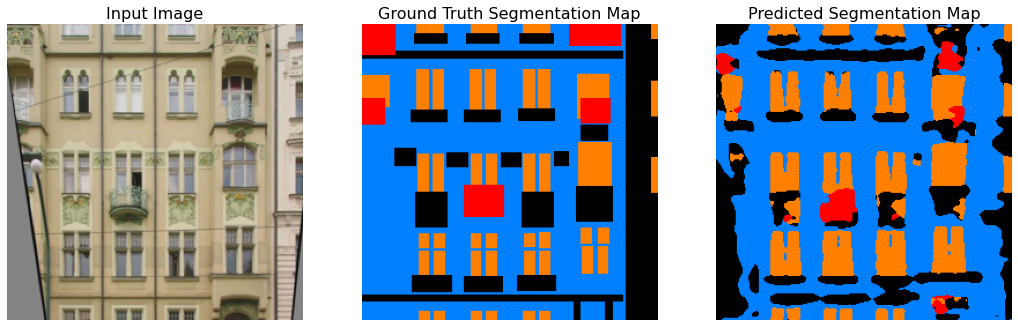

In [25]:
########################################################################
# TODO: Find a satisfactory result from the 114 test images            #
#       Submit the result in the pdf                                   #
# Note: Your submission doesn't have to be perfect.                    #
########################################################################
img_idx = 8
########################################################################
#                             END OF YOUR CODE                         #
########################################################################
output_dir = 'output_test'

plt.subplot(1, 3, 1)
plt.imshow(Image.open(os.path.join(output_dir, 'x{}.png'.format(img_idx))))
plt.title('Input Image', fontsize=16)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(Image.open(os.path.join(output_dir, 'gt{}.png'.format(img_idx))))
plt.title('Ground Truth Segmentation Map', fontsize=16)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(Image.open(os.path.join(output_dir, 'y{}.png'.format(img_idx))))
plt.title('Predicted Segmentation Map', fontsize=16)
plt.axis('off')

plt.gcf().set_size_inches(18, 10)
plt.show()

## Acknowledgement
The Mini Facade dataset are modified from CMP Facade Database by $Radim \ Tyle \check{c}ek$ and $Radim \ \check{S}a^{'}ra$. Please feel free to similarly re-use our problems while similarly crediting us.